In [1]:
import os
import joblib
import pandas as pd
import kagglehub
import transformers
import torch
import tqdm
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
)

# 1. Dataset Preparation


In [2]:
path = kagglehub.dataset_download(
    "suchintikasarkar/sentiment-analysis-for-mental-health"
)
print("Path to dataset files:", path)

Path to dataset files: /home/cici/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1


In [3]:
df = pd.read_csv(path + "/Combined Data.csv")
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [5]:
df = df.dropna()

In [6]:
dups = df.duplicated(subset=["statement"]).sum()
print(f"Total duplicate statements in entire dataset: {dups}")

dups_per_status = (
    df[df.duplicated(subset=["statement"], keep=False)].groupby("status").size()
)
print("\nDuplicates found per status:")
print(dups_per_status)

df = df.drop_duplicates(subset=["statement"], keep="first").copy()

Total duplicate statements in entire dataset: 1608

Duplicates found per status:
status
Anxiety                 433
Bipolar                 552
Depression              601
Normal                  463
Personality disorder    362
Stress                  574
Suicidal                 26
dtype: int64


In [7]:
drop = ["Anxiety", "Stress", "Bipolar", "Personality disorder"]

df = df[~df["status"].isin(drop)].copy()
df = df.reset_index(drop=True)

# 2. BERT Model Training and Evaluation


In [8]:
SEED = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.1
MODEL_DIR = "models"

In [9]:
torch.manual_seed(SEED)
os.makedirs(MODEL_DIR, exist_ok=True)

In [10]:
X = df["statement"]
y = df["status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=SEED, stratify=y
)

In [11]:
class BertSA:
    def __init__(self, model_name="bert-base-cased", num_labels=3):
        self.device = (
            torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
        )

        # model and tokenizer
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name, use_fast=True)
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name, num_labels=num_labels
        ).to(self.device)

        # label mappings (populated during fit)
        self.label2id = {}
        self.id2label = {}

        # training parameters
        self.lr = 5e-5
        self.weight_decay = 1e-3
        self.train_batch_size = 4
        self.grad_accum_steps = 4
        self.num_epochs = 2
        self.max_grad_norm = 1.0

        # inference parameters
        self.pred_batch_size = 4

    def encode(self, batch_texts, batch_labels=None):
        enc = self.tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            return_tensors="pt",
        )

        if batch_labels is not None:
            labels = [self.label2id[label] for label in batch_labels]
            enc["labels"] = torch.tensor(labels, dtype=torch.long)

        return enc

    def fit(self, X_train, y_train):
        N = len(X_train)
        # build label mapping from training data
        for label in sorted(set(y_train)):
            if label not in self.label2id:
                idx = len(self.label2id)
                self.label2id[label] = idx
                self.id2label[idx] = label

        # attach mappings to model config
        self.model.config.label2id = dict(self.label2id)
        self.model.config.id2label = dict(self.id2label)

        total_steps = int(
            N * self.num_epochs / (self.train_batch_size * self.grad_accum_steps)
        )

        opt = torch.optim.AdamW(
            self.model.parameters(), lr=self.lr, weight_decay=self.weight_decay
        )

        sch = transformers.get_constant_schedule_with_warmup(
            opt,
            num_warmup_steps=int(total_steps * 0.1),
        )

        self.model.train()
        for epoch in range(self.num_epochs):
            print(f"Epoch {epoch + 1}/{self.num_epochs}")

            total_loss = 0.0
            num_batches = 0

            indices = torch.randperm(N)
            opt.zero_grad(set_to_none=True)
            for start in tqdm.tqdm(range(0, N, self.train_batch_size)):
                num_batches += 1
                batch_indices = indices[start : start + self.train_batch_size].tolist()
                batch_texts = X_train.iloc[batch_indices].tolist()
                batch_labels = y_train.iloc[batch_indices].tolist()

                enc = self.encode(batch_texts, batch_labels)
                enc = {k: v.to(self.device, non_blocking=True) for k, v in enc.items()}

                outputs = self.model(**enc)
                loss = outputs.loss
                total_loss += loss.item()
                loss /= self.grad_accum_steps
                loss.backward()

                if (num_batches % self.grad_accum_steps) == 0 or (
                    start + self.train_batch_size >= N
                ):
                    torch.nn.utils.clip_grad_norm_(
                        self.model.parameters(), self.max_grad_norm
                    )
                    opt.step()
                    sch.step()
                    opt.zero_grad(set_to_none=True)

            avg_loss = total_loss / max(1, num_batches)
            print(f"  Average training loss: {avg_loss:.4f}")

    def predict(self, X):
        if not self.id2label:
            raise ValueError("Label mapping is empty. Call fit() before predict().")

        self.model.eval()
        preds = []

        for start in tqdm.tqdm(range(0, len(X), self.pred_batch_size)):
            batch_texts = X.iloc[start : start + self.pred_batch_size].tolist()
            enc = self.encode(batch_texts)
            enc = {k: v.to(self.device) for k, v in enc.items()}

            with torch.inference_mode():
                outputs = self.model(**enc)
                logits = outputs.logits
                batch_preds = torch.argmax(logits, dim=-1).cpu().tolist()
                batch_labels = [self.id2label[pred] for pred in batch_preds]
                preds.extend(batch_labels)

        return preds

In [12]:
# Train + evaluate (quick end-to-end check)
num_labels = y_train.nunique()
model_path = os.path.join(MODEL_DIR, "bert_sa_model.pkl")
is_trained = False
if os.path.exists(model_path):
    sa: BertSA = joblib.load(model_path)
    is_trained = True
else:
    sa = BertSA(model_name="bert-base-cased", num_labels=int(num_labels))

In [ ]:
if not is_trained:
    sa.fit(X_train, y_train)
    joblib.dump(sa, os.path.join(MODEL_DIR, "bert_sa_model.pkl"))

In [15]:
y_pred = sa.predict(X_test)

100%|██████████| 2089/2089 [02:04<00:00, 16.76it/s]


In [16]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

  Depression       0.82      0.78      0.80      3018
      Normal       0.96      0.99      0.98      3208
    Suicidal       0.73      0.75      0.74      2128

    accuracy                           0.85      8354
   macro avg       0.84      0.84      0.84      8354
weighted avg       0.85      0.85      0.85      8354



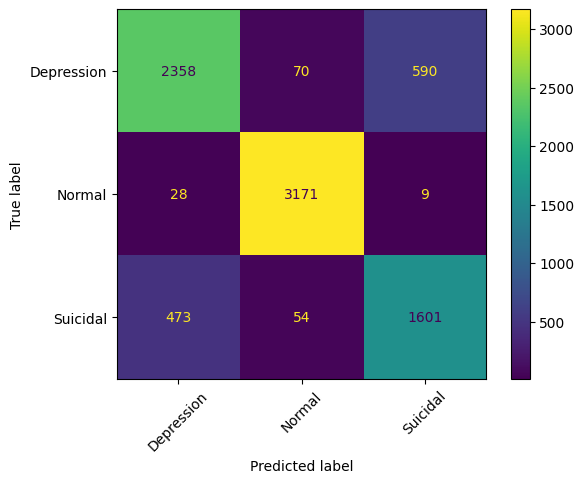

In [17]:
cm = confusion_matrix(y_test, y_pred, labels=sorted(y_test.unique()))

disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=sorted(y_test.unique())
)
disp.plot(xticks_rotation=45)

In [18]:
df = pd.Series(
    [
        "I feel so sad and hopeless all the time.",
        "I can't stop thinking about hurting myself.",
        "I'm really anxious about my upcoming exams.",
    ]
)
print(sa.predict(df))

100%|██████████| 1/1 [00:00<00:00, 128.12it/s]

['Suicidal', 'Normal', 'Normal']
